In [ ]:
! pip install kaggle


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
! mkdir ~/.kaggle


In [ ]:
# the path to the json file , please upload a json file in yourgoogle drive
!cp  ./kaggle.json  ~/.kaggle


In [ ]:
! kaggle datasets download  ismailnasri20/driver-drowsiness-dataset-ddd


In [ ]:
! unzip  ./driver-drowsiness-dataset-ddd.zip

In [ ]:
# Imports here
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import  transforms, models , datasets
from torch.utils.data import DataLoader , Dataset
from tqdm import tqdm  # For progress bars
from collections import OrderedDict
from PIL import Image
import json
from collections import OrderedDict
from sklearn.model_selection import KFold
import os
import numpy as np
from collections import defaultdict

In [ ]:
#for my specific device's GPU  adjust for other hardware as needed.

print(torch.__version__)
import torch

if torch.backends.mps.is_available():
    print("GPU is available.")
    device = torch.device('mps')
else:
    print("GPU is not available.")
    device = torch.device('cpu')






In [ ]:
#!pip install split-folders


In [ ]:
# create a class for our data set to use dataloders
class DriverDrowsinessDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
 # delete later
#import splitfolders

#data_dir = '/content/Driver Drowsiness Dataset (DDD)'
#output_dir = '/content/splitted_Data'
#splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(0.8, 0.15, 0.05))

In [ ]:
# delete later
#train_dir = "/content/splitted_Data/train"
#test_dir = "/content/splitted_Data/train"
#valid_dir = "/content/splitted_Data/val"



In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


In [ ]:
!pip install mediapipe
import cv2
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import mediapipe as mp
!pip install dlib
import dlib

base_folder = './Driver Drowsiness Dataset (DDD)'
drowsy_folder = os.path.join(base_folder, 'Drowsy')
non_drowsy_folder = os.path.join(base_folder, 'Non Drowsy')

video_groups = defaultdict(list)

folders = [drowsy_folder, non_drowsy_folder]
labels_dict = {}

for folder in folders:
    label = 0 if 'Non Drowsy' in folder else 1
    for img_name in os.listdir(folder):
        video_id = img_name[0].lower()  # Convert starting letter to lowercase
        # in the dataset all frames belonging to the same video start  with the same letter except for z which has 3 diffrent videos  za zb zc
        if video_id == 'z' :
            video_id = img_name[0:2].lower()
        video_groups[video_id].append(os.path.join(folder, img_name))
        labels_dict[os.path.join(folder, img_name)] = label

# Load the face and eye detectors using Viola-Jones
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Download this file!
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

# Function to process a single image
def process_image(image_path):
    img = cv2.imread(image_path)

    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        # Convert the image to RGB (MediaPipe expects RGB input)
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Check if any faces were detected
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Get eye landmarks (indices for left and right eye)
                left_eye_landmarks = [33, 133, 159, 145, 158, 153, 144, 163, 7, 33, 160, 144, 159, 145, 133, 153, 158, 154, 157, 173, 33, 246, 161, 160, 159, 158, 157, 173]
                right_eye_landmarks = [362, 382, 380, 374, 381, 373, 385, 386, 263, 249, 390, 373, 380, 374, 382, 385, 381, 387, 388, 466, 263, 466, 388, 387, 386, 385, 384, 398]

                # Get eye region coordinates
                left_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                   int(face_landmarks.landmark[idx].y * img.shape[0]))
                                  for idx in left_eye_landmarks]
                right_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                    int(face_landmarks.landmark[idx].y * img.shape[0]))
                                   for idx in right_eye_landmarks]

                # Draw circles or rectangles around eye regions (optional)
                for point in left_eye_points + right_eye_points:
                    cv2.circle(img, point, 2, (0, 255, 0), -1)  # Draw green circles

    # Display the image with eye regions highlighted
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Eye Regions Detected')
    plt.show()
for image_path in labels_dict.keys():  # Iterate through image paths in labels_dict
    process_image(image_path)
# sepreate test set
video_group_keys = list(video_groups.keys())
np.random.shuffle(video_group_keys)
test_size = int(0.2 * len(video_group_keys))
test_groups = video_group_keys[:test_size]
train_val_groups = video_group_keys[test_size:]

# Create file paths and labels for test set
test_files = [file for group in test_groups for file in video_groups[group]]
test_labels = [labels_dict[file] for file in test_files]


k_folds = 5
folds = [[] for _ in range(k_folds)]

for idx, video_id in enumerate(train_val_groups):
    folds[idx % k_folds].extend(video_groups[video_id])


for fold_idx, fold_files in enumerate(folds, 1):
    print(f"Fold {fold_idx}")
    # print groups in each fold
    starting_letters = []
    for file in fold_files:
      base_name = os.path.basename(file).lower()
      if base_name[0]=='z':
        starting_letters.append(base_name[0:2])
      else:
        starting_letters.append(base_name[0])

    unique_starting_letters = sorted(set(starting_letters))
    print(f"Starting Letters: {unique_starting_letters}")
    print(f"Total files in fold: {len(fold_files)}")
    print("-" * 30)



In [ ]:
data_transforms = {
    'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                ]),
    'valid': transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                              ]),
    'test': transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                              ])

}
'''
# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir,transform = data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir,transform = data_transforms['valid']),
    'test':datasets.ImageFolder(test_dir,transform= data_transforms['test'])

}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders ={'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=True)
}
'''

In [ ]:
model = models.resnet50(pretrained=True)
print(model)



In [ ]:
# freeze paramters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# this just a base code we can change the number of nodes and layers
fc = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(2048,512,bias=True)),
    ('relu' ,nn.ReLU()),
    ('dropout',nn.Dropout(0.2)),
    ('f2', nn.Linear(512,512,bias=True)),
    ('dropout',nn.Dropout(0.2)),
    ('f3', nn.Linear(512,1,bias=True)),]))
model.fc = fc

In [ ]:

def train_model(model, trainloader, validloader, criterion, optimizer, num_epochs=20, print_every=2, device='cpu'):

    for e in range(num_epochs):

        # Training Phase
        train_accuracy = 0
        running_loss = 0
        model.train()

        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            log_ps = model(images)  # Forward pass (raw logits)
            loss = criterion(log_ps, labels.view(-1, 1).float())  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy for training
            with torch.no_grad():
                ps = torch.sigmoid(log_ps)
                top_class = ps >= 0.5  # Threshold of 0.5 for binary classification (1 or 0)
                equals = top_class == labels.view(*top_class.shape)  #
                train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Print average losses and validation accuracy at specified intervals
        if (e + 1) % print_every == 0:
            test_loss = 0
            valid_accuracy = 0
            model.eval()  # Set to evaluation mode
            with torch.no_grad():  # Disable gradient computation during validation
                for inputs, labels in tqdm(validloader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    log_ps = model(inputs)  # Forward pass (raw logits)
                    batch_loss = criterion(log_ps, labels.view(-1, 1).float())
                    test_loss += batch_loss.item()

                    # Calculate accuracy for validation
                    ps = torch.sigmoid(log_ps)  # Apply sigmoid for thresholding
                    top_class = ps >= 0.5  # Use threshold of 0.5 for classification
                    equals = top_class == labels.view(*top_class.shape)
                    valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Print training and validation statistics
            print(f"Epoch {e+1}/{num_epochs}.. "
                  f"Train loss: {running_loss/len(trainloader):.3f}.. "
                  f"Training accuracy: {train_accuracy/len(trainloader):.3f}.. "
                  f"Validation loss: {test_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {valid_accuracy/len(validloader):.3f}")

            # Reset variables for next epoch
            running_loss = 0
            train_accuracy = 0

            model.train()  # Switch back to training mode

    return model, test_loss , valid_accuracy



In [ ]:
all_fold_val_losses = []
all_fold_val_accuracies = []

# Cross-validation loop
for fold_idx in range(k_folds):
    print
    val_files = folds[fold_idx]
    train_files = []
    for idx  in range(len(folds)):
      if idx != fold_idx:
          for file in folds[idx]:
            train_files.append(file)

    val_labels = [labels_dict[file] for file in val_files]
    train_labels = [labels_dict[file] for file in train_files]

    train_dataset = DriverDrowsinessDataset(train_files, train_labels, transform = data_transforms['train'])
    val_dataset = DriverDrowsinessDataset(val_files, val_labels, transform = data_transforms['valid'])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last = True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True,drop_last = True)
    criterion =  nn.BCEWithLogitsLoss()
    model.to(device)
    optimizer = optim.Adam(fc.parameters(), lr=0.003)
    trained_model, valid_loss, valid_accuracy  = train_model(model, train_loader ,val_loader, criterion, optimizer, num_epochs=20 ,device = device)
    all_fold_val_losses.append(valid_loss)
    all_fold_val_accuracies.append(valid_accuracy)







In [ ]:
!pip install opencv-python # Install OpenCV.

In [ ]:
import cv2

def detect_eyes(image_path):
  """Detects eyes in an image using Viola-Jones."""
  eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')  # Use eye cascade
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

  if len(eyes) > 0:
    (x, y, w, h) = eyes[0]  # Get bounding box of the first detected eye
    eye_img = img[y:y + h, x:x + w]
    return eye_img
  else:
    return None

In [ ]:
class DriverDrowsinessDataset(Dataset):
    # ... (Existing code) ...

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Detect eyes using Viola-Jones
        eye_img = detect_eyes(img_path)

        if eye_img is not None:
            image = Image.fromarray(eye_img).convert('RGB')  # Convert to PIL Image

            if self.transform:
                image = self.transform(image)

            return image, label
        else:
            # Handle cases where no eyes are detected (e.g., skip the image)
            # You can raise an exception, return a default image, or remove the image from the dataset.
            raise Exception(f"No eyes detected in image: {img_path}")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def visualize_eye_detection(image_path):
    """Visualizes eye detection on an image."""
    img = cv2.imread(image_path)

    # Check if image was loaded successfully
    if img is None:
        print(f"Error: Could not load image at path: {image_path}")
        return  # Exit the function if image loading failed

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in eyes:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw rectangle around eyes

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
    plt.title('Eye Detection')
    plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# Define eye_cascade outside the functions so it's globally accessible
eye_cascade_path = cv2.data.haarcascades + 'haarcascade_eye.xml'

# Check if the cascade file exists
if not os.path.exists(eye_cascade_path):
    print(f"Error: Cascade file not found at {eye_cascade_path}")
else:
    print(f"Cascade file found at {eye_cascade_path}")

eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

# Check if the cascade was loaded successfully
if eye_cascade.empty():
    print("Error: Could not load eye cascade classifier.")
else:
    print("Eye cascade classifier loaded successfully.")

def visualize_eye_detection(image_path, eye_cascade):  # Pass eye_cascade as an argument
    """Visualizes eye detection on an image."""
    # Print the image path to verify correctness
    print(f"Attempting to load image from: {image_path}")

    # Load the image
    img = cv2.imread(image_path)  # Assign value to img

    # Check if image was loaded successfully
    if img is None:
        print(f"Error: Could not load image at path: {image_path}")
        return  # Exit the function if image loading failed

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Assign value to gray

    # Detect eyes with adjusted parameters
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    # Print the number of detected eyes
    print(f"Number of detected eyes: {len(eyes)}")

    # Draw rectangles around the detected eyes
    for (x, y, w, h) in eyes:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the image with detected eyes
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Eye Detection")
    plt.show()




In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the eye cascade classifier
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Check if the cascade was loaded successfully
if eye_cascade.empty():
    print("Error: Could not load eye cascade classifier.")
else:
    print("Eye cascade classifier loaded successfully.")

    try:
        # Get the features from the cascade
        features = eye_cascade.getOriginalWindowSize()
        num_features = eye_cascade.getFeatureType()

        # Create a blank image to visualize the features
        feature_img = np.zeros((features[1], features[0], 3), dtype=np.uint8)

        # Draw the features on the image
        for i in range(num_features):
            # Get the feature's rectangle and weight
            rect = eye_cascade.getFeatureParams(i)
            weight = rect[4]

            # Draw the rectangle with color based on weight
            color = (255, 255, 255) if weight > 0 else (0, 0, 0)
            cv2.rectangle(feature_img, (int(rect[0]), int(rect[1])),
                          (int(rect[0] + rect[2]), int(rect[1] + rect[3])),
                          color, -1)

        # Display the feature image
        plt.imshow(feature_img)
        plt.title('Haar-like Features for Eye Detection')
        plt.show()

    except Exception as e:
        print(f"Error visualizing features: {e}")

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
# Load the image
image_path = './Driver Drowsiness Dataset (DDD)/Non Drowsy/y0998.png'  # Replace with your image path
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

# Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]  # Region of Interest (ROI) for eyes within the face
    roi_color = img[y:y + h, x:x + w]  # ROI in color for drawing eye rectangles

    # Detect eyes within the face ROI
    eyes = eye_cascade.detectMultiScale(roi_gray)

    # Draw rectangles around the detected eyes
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)  # Draw eye rectangle

# Display the image with detected faces and eyes
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Face and Eye Detection')
# Display the image with detected faces


In [ ]:

import cv2
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets
from IPython.display import display

# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Function to handle uploaded file
def handle_upload(change):
    global image_path, img  # Declare image_path and img as global
    uploaded_filename = next(iter(uploader.value))
    content = uploader.value[uploaded_filename]['content']
    with open(uploaded_filename, 'wb') as f:
        f.write(content)
    image_path = uploaded_filename
    img = cv2.imread(image_path)
    process_image()

# Function to process the image
def process_image():
    global img
    if img is not None:
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        # Draw rectangles around the detected faces
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            roi_gray = gray[y:y + h, x:x + w]  # Region of Interest (ROI) for eyes within the face
            roi_color = img[y:y + h, x:x + w]  # ROI in color for drawing eye rectangles

            # Detect eyes within the face ROI
            eyes = eye_cascade.detectMultiScale(roi_gray)

            # Draw rectangles around the detected eyes
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)  # Draw eye rectangle

        # Display the image with detected faces and eyes
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Face and Eye Detection')
        plt.show()
    else:
        print(f"Error: Could not load image at path: {image_path}")

# Create an upload widget
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False  # Allow only one file to be uploaded
)

# Observe changes in the upload widget
uploader.observe(handle_upload, names='value')

# Display the upload widget
display(uploader)

In [ ]:
!pip install mediapipe

import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Load the image
image_path = './Driver Drowsiness Dataset (DDD)/Non Drowsy/y0998.png'  # Replace with your image path
img = cv2.imread(image_path)

# Convert to RGB (MediaPipe expects RGB input)
results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Check if face is detected
!pip install mediapipe

import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Load the image
image_path = './Driver Drowsiness Dataset (DDD)/Non Drowsy/y0998.png'  # Replace with your image path
img = cv2.imread(image_path)

# Convert to RGB (MediaPipe expects RGB input)
results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Check if face is detected
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        pass

In [ ]:
!pip install mediapipe

import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Load the image
image_path = './Driver Drowsiness Dataset (DDD)/Non Drowsy/y0998.png'  # Replace with your image path
img = cv2.imread(image_path)

# Convert to RGB (MediaPipe expects RGB input)
results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#

In [ ]:
%matplotlib inline

In [ ]:
!pip install mediapipe opencv-python
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Google Colab

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

# Load the image
img = cv2.imread('Driver Drowsiness Dataset (DDD)/Non Drowsy/y0955.png')  # Replace 'photo.jpg' with your image path

# Check if the image was loaded successfully
if img is None:
    print("Error: Could not load image. Please check the image path and file existence.")
else:
    # Process the image with MediaPipe Face Mesh
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        # Convert the image to RGB (MediaPipe expects RGB input)
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Check if any faces were detected
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Draw the face mesh landmarks on the image
                mp_drawing.draw_landmarks(
                    image=img,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing.DrawingSpec(
                        color=(0, 255, 0), thickness=1, circle_radius=1
                    ),
                )

    # Display the image with the detected eye landmarks
    cv2_imshow(img)  # Use cv2_imshow instead of cv2.imshow in Google Colab
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the image (optional)
    output_path = "eye_detection_output.png"
    cv2.imwrite(output_path, img)
    print(f"Image saved to: {output_path}")

In [ ]:
!pip install mediapipe opencv-python
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Google Colab

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

# Load the image
img = cv2.imread('Driver Drowsiness Dataset (DDD)/Non Drowsy/y0955.png')  # Replace 'photo.jpg' with your image path

# Check if the image was loaded successfully
if img is None:
    print("Error: Could not load image. Please check the image path and file existence.")
else:
    # Process the image with MediaPipe Face Mesh
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        # Convert the image to RGB (MediaPipe expects RGB input)
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Check if any faces were detected
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Get eye landmarks (indices for left and right eye)
                left_eye_landmarks = [466, 475, 477, 474, 476] # adjust landmarks as needed
                right_eye_landmarks = [130, 145, 155, 153, 159]  # adjust landmarks as needed

                # Get eye region coordinates
                left_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                   int(face_landmarks.landmark[idx].y * img.shape[0]))
                                  for idx in left_eye_landmarks]
                right_eye_points

In [ ]:
!pip install mediapipe opencv-python matplotlib
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

# Load the image
img = cv2.imread('Driver Drowsiness Dataset (DDD)/Non Drowsy/y0955.png')

# Check if the image was loaded successfully
if img is None:
    print("Error: Could not load image. Please check the image path and file existence.")
else:
    # Process the image with MediaPipe Face Mesh
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        # Convert the image to RGB (MediaPipe expects RGB input)
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Check if any faces were detected
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Get eye landmarks (indices for left and right eye)
                left_eye_landmarks = [466, 475, 477, 474, 476]  # Adjust landmarks as needed
                right_eye_landmarks = [130, 145, 155, 153, 159]  # Adjust landmarks as needed

                # Get eye region coordinates
                left_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                   int(face_landmarks.landmark[idx].y * img.shape[0]))
                                  for idx in left_eye_landmarks]
                right_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                    int(face_landmarks.landmark[idx].y * img.shape[0]))
                                   for idx in right_eye_landmarks]

                # Visualize detected eyes on the original image
                for point in left_eye_points + right_eye_points:
                    cv2.circle(img, point, 2, (0, 0, 255), -1)  # Draw red circles on eye landmarks

                # Crop and display the eyes
                # Left eye
                x_min_left = min(p[0] for p in left_eye_points)
                x_max_left = max(p[0] for p in left_eye_points)
                y_min_left = min(p[1] for p in left_eye_points)
                y_max_left = max(p[1] for p in left_eye_points)
                left_eye_img = img[y_min_left:y_max_left, x_min_left:x_max_left]

                # Right eye
                x_min_right = min(p[0] for p in right_eye_points)
                x_max_right = max(p[0] for p in right_eye_points)
                y_min_right = min(p[1] for p in right_eye_points)
                y_max_right = max(p[1] for p in right_eye_points)
                right_eye_img = img[y_min_right:y_max_right, x_min_right:x_max_right]

                # Display the images using Matplotlib
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Original image with eye landmarks
                plt.title("Original Image")

                plt.subplot(1, 3, 2)
                plt.imshow(cv2.cvtColor(left_eye_img, cv2.COLOR_BGR2RGB))  # Cropped left eye
                plt.title("Left Eye")

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(right_eye_img, cv2.COLOR_BGR2RGB))  # Cropped right eye

In [ ]:
def test_model(model, testloader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Turn off gradients for testing
        for images, labels in tqdm(testloader):
            images, labels = images.to(device), labels.to(device)  # Move to device
            log_ps = model(images)  # Forward pass
            loss = criterion(log_ps, labels.view(-1, 1).float())
            test_loss += loss.item()
            ps = torch.sigmoid(log_ps)  # Apply sigmoid for thresholding
            top_class = ps >= 0.5  # Use threshold of 0.5 for classification
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    test_accuracy = total_correct / total_samples
    print(f"Test Accuracy: {test_accuracy:.3f}")

In [ ]:
!pip install mediapipe opencv-python matplotlib
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files

# Upload the image to Colab
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the path of the uploaded image

# ... (rest of the code remains the same, but use image_path for cv2.imread)
img = cv2.imread(image_path)

# ... (continue with the face detection and eye cropping logic)

Saving A0254.png to A0254 (1).png
Image loaded successfully.


<ipython-input-2-b57ab6c0e4c4>:78: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 3)


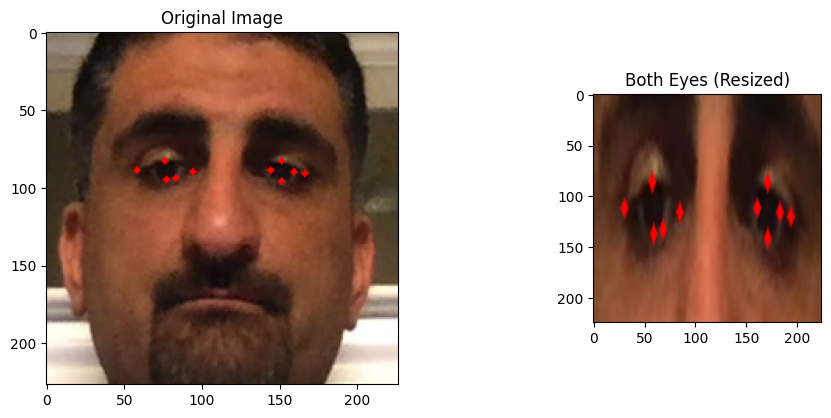

Image saved to: eye_landmarks_output.jpg


In [2]:
!pip install mediapipe opencv-python matplotlib
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files

# Upload the image to Colab
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the path of the uploaded image

# Load the image and check for errors
img = cv2.imread(image_path)
if img is None:
    print("Error: Could not load image. Please check the image path and file existence.")
else:
    print("Image loaded successfully.")

    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh

    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        # Convert the image to RGB (MediaPipe expects RGB input)
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Check if any faces were detected
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Get eye landmarks (indices for left and right eye)
                left_eye_landmarks = [466, 475, 477, 474, 476]
                right_eye_landmarks = [130, 145, 155, 153, 159]


               # Get eye region coordinates
                left_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                   int(face_landmarks.landmark[idx].y * img.shape[0]))
                                  for idx in left_eye_landmarks] # iterate through landmark indices
                right_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                    int(face_landmarks.landmark[idx].y * img.shape[0]))
                                   for idx in right_eye_landmarks] # iterate through landmark indices
for point in left_eye_points + right_eye_points:
    cv2.circle(img, point, 2, (0, 0, 255), -1)  # Draw red circles on landmarks
all_eye_points = left_eye_points + right_eye_points

# Cropping logic with margin/padding for both eyes
margin = 20  # Adjust this value to control the zoom level

x_min = min(p[0] for p in all_eye_points) - margin
x_max = max(p[0] for p in all_eye_points) + margin
y_min = min(p[1] for p in all_eye_points) - margin
y_max = max(p[1] for p in all_eye_points) + margin

# Ensure coordinates are within image bounds
x_min = max(0, x_min)
x_max = min(img.shape[1], x_max)
y_min = max(0, y_min)
y_max = min(img.shape[0], y_max)

# Crop the image to include both eyes
both_eyes_img = img[y_min:y_max, x_min:x_max]
resized_image = cv2.resize(both_eyes_img, (224, 224))
# ... (rest of your existing code) ...

# Display or save the output image (modified)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Original image with eye landmarks
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(both_eyes_img, cv2.COLOR_BGR2RGB))  # Cropped image with both eyes
plt.title("Both Eyes")
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Resized image
plt.title("Both Eyes (Resized)")


plt.show()
# Option 2: Save the image to a file
output_image_path = "eye_landmarks_output.jpg"  # Choose a filename
cv2.imwrite(output_image_path, img)
print(f"Image saved to: {output_image_path}")

In [4]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_face_mesh = mp.solutions.face_mesh

def detect_eyes(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Initialize MediaPipe Face Mesh
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        # Convert the image to RGB (MediaPipe expects RGB input)
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Check if any faces were detected
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Get eye landmarks (indices for left and right eye)
                # Adjust landmarks as needed for your desired eye region
                left_eye_landmarks = [33, 133, 159, 145, 158, 153, 144, 163, 7, 33, 160, 144, 159, 145, 133, 153, 158, 154, 157, 173, 33, 246, 161, 160, 159, 158, 157, 173]
                right_eye_landmarks = [362, 382, 380, 374, 381, 373, 385, 386, 263, 249, 390, 373, 380, 374, 382, 385, 381, 387, 388, 466, 263, 466, 388, 387, 386, 385, 384, 398]


                # Get eye region coordinates
                left_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                   int(face_landmarks.landmark[idx].y * img.shape[0]))
                                  for idx in left_eye_landmarks] # iterate through landmark indices
                right_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                    int(face_landmarks.landmark[idx].y * img.shape[0]))
                                   for idx in right_eye_landmarks] # iterate through landmark indices
                # Crop eyes
                all_eye_points = left_eye_points + right_eye_points

                margin = 20  # Adjust this value to control the padding amount

                x_min = min(p[0] for p in all_eye_points) - margin
                x_max = max(p[0] for p in all_eye_points) + margin
                y_min = min(p[1] for p in all_eye_points) - margin
                y_max = max(p[1] for p in all_eye_points) + margin

                # Ensure coordinates are within image bounds
                x_min = max(0, x_min)
                x_max = min(img.shape[1], x_max)
                y_min = max(0, y_min)
                y_max = min(img.shape[0], y_max)

                # Crop the image to include both eyes
                eye_img = img[y_min:y_max, x_min:x_max]

                return eye_img # return cropped image with landmarks
    return None

In [8]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

mp_face_mesh = mp.solutions.face_mesh

def detect_eyes(image_path):
    """Detects eyes in an image using MediaPipe Face Mesh."""
    img = cv2.imread(image_path)

    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Eye landmarks (adjust as needed)
                left_eye_landmarks = [33, 133, 159, 145, 158, 153, 144, 163, 7, 33, 160, 144, 159, 145, 133, 153, 158, 154, 157, 173, 33, 246, 161, 160, 159, 158, 157, 173]
                right_eye_landmarks = [362, 382, 380, 374, 381, 373, 385, 386, 263, 249, 390, 373, 380, 374, 382, 385, 381, 387, 388, 466, 263, 466, 388, 387, 386, 385, 384, 398]

                # Eye region coordinates
                left_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                   int(face_landmarks.landmark[idx].y * img.shape[0]))
                                  for idx in left_eye_landmarks]
                right_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                    int(face_landmarks.landmark[idx].y * img.shape[0]))
                                   for idx in right_eye_landmarks]

                # Crop eyes with padding
                all_eye_points = left_eye_points + right_eye_points
                margin = 20  # Padding amount

                x_min = min(p[0] for p in all_eye_points) - margin
                x_max = max(p[0] for p in all_eye_points) + margin
                y_min = min(p[1] for p in all_eye_points) - margin
                y_max = max(p[1] for p in all_eye_points) + margin

                # Ensure coordinates are within image bounds
                x_min = max(0, x_min)
                x_max = min(img.shape[1], x_max)
                y_min = max(0, y_min)
                y_max = min(img.shape[0], y_max)

                # Crop the image
                eye_img = img[y_min:y_max, x_min:x_max]

                return eye_img

    return None


def process_and_plot_image(image_path):
    """Processes the selected image and displays the results."""
    eye_img = detect_eyes(image_path)

    if eye_img is not None:
        plt.imshow(cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB))
        plt.title("Detected Eyes")
        plt.show()
    else:
        print("Error: Eyes not detected in the image.")


import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

mp_face_mesh = mp.solutions.face_mesh

def detect_eyes(image_path):
    """Detects eyes in an image using MediaPipe Face Mesh."""
    img = cv2.imread(image_path)

    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Eye landmarks (adjust as needed)
                left_eye_landmarks = [33, 133, 159, 145, 158, 153, 144, 163, 7, 33, 160, 144, 159, 145, 133, 153, 158, 154, 157, 173, 33, 246, 161, 160, 159, 158, 157, 173]
                right_eye_landmarks = [362, 382, 380, 374, 381, 373, 385, 386, 263, 249, 390, 373, 380, 374, 382, 385, 381, 387, 388, 466, 263, 466, 388, 387, 386, 385, 384, 398]

                # Eye region coordinates
                left_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                   int(face_landmarks.landmark[idx].y * img.shape[0]))
                                  for idx in left_eye_landmarks]
                right_eye_points = [(int(face_landmarks.landmark[idx].x * img.shape[1]),
                                    int(face_landmarks.landmark[idx].y * img.shape[0]))
                                   for idx in right_eye_landmarks]

                # Crop eyes with padding
                all_eye_points = left_eye_points + right_eye_points
                margin = 20  # Padding amount

                x_min = min(p[0] for p in all_eye_points) - margin
                x_max = max(p[0] for p in all_eye_points) + margin
                y_min = min(p[1] for p in all_eye_points) - margin
                y_max = max(p[1] for p in all_eye_points) + margin

                # Ensure coordinates are within image bounds
                x_min = max(0, x_min)
                x_max = min(img.shape[1], x_max)
                y_min = max(0, y_min)
                y_max = min(img.shape[0], y_max)

                # Crop the image
                eye_img = img[y_min:y_max, x_min:x_max]

                return eye_img

    return None


def process_and_plot_image(image_path):
    """Processes the selected image and displays the results."""
    eye_img = detect_eyes(image_path)

    if eye_img is not None:
        plt.imshow(cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB))
        plt.title("Detected Eyes")
        plt.show()
    else:
        print("Error: Eyes not detected in the image.")


# Create an upload widget
uploader = widgets.FileUpload(accept='image/*')

# Create a button to process the image
button = widgets.Button(description='Process Image')

# Function to handle button

In [ ]:


def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1, 1).float())
            test_loss += loss.item() * images.size(0)  # Accumulate test loss

            # Convert outputs to binary predictions
            predictions = (torch.sigmoid(outputs) >= 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)


    average_test_loss = test_loss / total_samples
    accuracy = correct_predictions / total_samples

    print(f"Test Loss: {average_test_loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return average_test_loss, accuracy


test_dataset = DriverDrowsinessDataset(test_files, test_labels, transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Run the test function
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
test_loss, test_accuracy = test_model(model, test_loader, criterion, device)


In [ ]:
# code copied from another project i worked on still need updating to fit our project

In [ ]:
#save  trained model   to a file to use later
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {
    'epoch': 30,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': model.class_to_idx
}

torch.save(checkpoint, 'model_checkpoint.pth')


In [ ]:
#  function that loads a checkpoint and rebuilds the model
checkpoint = torch.load('./model_checkpoint.pth')
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

Classifer= nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(100,512,bias=True)),
    ('relu' ,nn.ReLU()),
    ('dropout',nn.Dropout(0.2)),
    ('f2', nn.Linear(512,102)),
    ('output',nn.LogSoftmax(dim=1)) ]))
model.fc = fc
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.class_to_idx = checkpoint['class_to_idx']

